# ProB2 Jupyter Notebook Overview

In this jupyter notebook, we will give you an extended overview of the functionalities that come with the ProB2 jupyter kernel.
For this purpose, we will take a look at the simple machine `Lift.mch` taken from the [ProB Public Examples](https://www3.hhu.de/stups/downloads/prob/source/).

## The Help Command

If you want to find out more about the commands and how to use them, type in `:help [COMMAND]`. The ProB2 Jupyter Notebook has an autocompletion function which also helps you to find what you need. Simply press `TAB` after the space after `:help`.

In [1]:
:help :help

```
:help [COMMAND]
```

Display help for a specific command, or general help about the REPL.

## Loading a Machine

To start of with the ProB Jupyter Kernel, we have to load a machine. This can be done by typing `::load` in a Code cell before the machine code and pressing `Shift+Enter`.

In [2]:
:help ::load

```
::load [PREF=VALUE ...]
MACHINE
...
END
```

Load the machine source code given in the cell body.

There must be a newline between the `::load` command name and the machine code.

Any number of preference assignments may be included after `::load` (only on the first line). Preferences can also be changed on a loaded machine using the `:pref` command, however certain preferences do not take full effect when set using `:pref` and must be set when the machine is loaded.

In [3]:
::load DOT=/usr/bin/dot
MODEL Lift
DEFINITIONS SET_PREF_SHOW_EVENTB_ANY_VALUES==TRUE;
  ASSERT_LTL == "G( [push_call_button(groundf)] => F {cur_floor=groundf & door_open=TRUE})";
  Rconv == (topf-r+groundf);
CONSTANTS groundf,topf
PROPERTIES
  topf : INTEGER & groundf : INTEGER & (groundf = -1) & (topf = 2) & (groundf < topf)
VARIABLES call_buttons,cur_floor,direction_up,door_open
INVARIANT
       cur_floor : (groundf .. topf) & 
       door_open : BOOL & 
       call_buttons : POW(groundf .. topf) &
       direction_up : BOOL &
       (door_open = TRUE => cur_floor : call_buttons)
INITIALISATION cur_floor := (groundf) || door_open := FALSE || call_buttons := ({}) || direction_up := TRUE
OPERATIONS
 move_up = SELECT door_open = FALSE & cur_floor < topf & direction_up = TRUE &
             # c.((c : INTEGER) & ((c : INTEGER) & (c > cur_floor) & (c : call_buttons))) &
            (cur_floor /: call_buttons) THEN
   cur_floor := ((cur_floor)+(1))
 END ;
 move_down = SELECT door_open = FALSE & cur_floor > groundf & (direction_up = FALSE) &
       # cu.((cu : INTEGER) & ((cu : INTEGER) & (cu < cur_floor) & (cu : call_buttons))) &
      (cur_floor /: call_buttons) THEN
   cur_floor := ((cur_floor)-(1))
 END ;
 reverse_lift_up = SELECT direction_up = FALSE & door_open = FALSE &
   # c.((c : INTEGER) & ((c : INTEGER) & (c > cur_floor) & (c : call_buttons))) & 
   ! l.((l : INTEGER) => (((l : INTEGER) & (l <= cur_floor) & (l >= groundf)) => (l /: call_buttons))) THEN
   direction_up := TRUE
 END ;
 reverse_lift_down = SELECT direction_up = TRUE & door_open = FALSE & 
  # cd.(cd : INTEGER & ((cd : INTEGER) & (cd < cur_floor) & (cd : call_buttons))) & 
  ! u.(u : INTEGER => (((u : INTEGER) & (u >= cur_floor) & (u <= topf)) => (u /: call_buttons))) THEN
  direction_up := FALSE
 END ;
 open_door = SELECT door_open = FALSE & (cur_floor : call_buttons) THEN
    door_open := TRUE
 END ;
 close_door = SELECT door_open = TRUE THEN
    door_open := FALSE || call_buttons := ((call_buttons)\({cur_floor}))
 END ;
 push_call_button(floor) = SELECT (floor : (groundf .. topf)) & (floor /: call_buttons) THEN 
     call_buttons := ((call_buttons)\/({floor}))
 END 
END

Loaded machine: Lift

## Initialising a Machine

Now we will set up constants and initialise the machine, to be able to interact with it. You can set up constants with the commant `:constants` and initialise with the command `:init`. 

In [4]:
:help :constants

```
:constants [PREDICATE]
```

Set up the current machine's constants.

This is a shorthand for `:exec SETUP_CONSTANTS [PREDICATE]`.

In [5]:
:constants

Machine constants set up using operation 0: $setup_constants()

In [6]:
:help :init

```
:init [PREDICATE]
```

Initialise the current machine with the specified predicate

This is a shorthand for `:exec INITIALISATION [PREDICATE]`.

In [7]:
:init

Machine initialised using operation 1: $initialise_machine()

## Trace and State

After loading and initialising the machine, we can explore the state, visualise the machine and state and more. We will start by finding out in which trace we are currently in, to ensure, that we initialised the machine. This can be done with the command `:trace`.

In [8]:
:help :trace

```
:trace
```

Display all states and transitions in the current trace.

Each state has an index, which can be passed to the `:goto` command to go to that state.

The first state (index -1) is always the root state. All other states are reached from the root state by following (previously executed) transitions.

In [9]:
:trace

* -1: Root state
* 0: `SETUP_CONSTANTS()`
* 1: `INITIALISATION()` **(current)**

Switching to a different trace is possible by typing in `:goto INDEX`.

In [10]:
:help :goto

```
:goto INDEX
```

Go to the state with the specified index in the current trace.

Use the `:trace` command to view the current trace and the indices of its states. Index -1 refers to the root state and is always available.

Going backwards in the current trace does *not* discard any parts of the trace, so it is possible to go forward again afterwards. However, executing an operation in a state *will* discard any parts of the trace after that state (and replace them with the destination state of the executed transition).

In [11]:
:goto -1

Changed to state with index -1

In [12]:
:trace

* -1: Root state **(current)**
* 0: `SETUP_CONSTANTS()`
* 1: `INITIALISATION()`

Now that we set the current state to -1, we are at out root state again. We did not set up constants or initialise the machine, yet. From here, we have two possibilities to go back to the initialised state. Either by setting up constants and initialising again, or by simply typing `:goto 1`.

In [13]:
:goto 1

Changed to state with index 1

In [14]:
:trace

* -1: Root state
* 0: `SETUP_CONSTANTS()`
* 1: `INITIALISATION()` **(current)**

Another feature of ProB is, that you can find a state, for which a predicate is true. In the following we will try to use it:

In [16]:
:help :find

```
:find PREDICATE
```

Try to find a state for which the given predicate is true (in addition to the machine's invariant).

If such a state is found, it is made the current state, otherwise an error is displayed.

Note that this command does not necessarily find a valid *trace* to the found state. Instead, in some cases a single "fake" transition is added to the trace, which goes directly to the found state and does not use the machine's operations to reach it.

In [17]:
:find cur_floor=0

Found a matching state and made it current state

In [18]:
:trace

* -1: Root state
* 0: `find_valid_state` **(current)**

Note that the command leaves us with the root state and the current state, with a valid trace. That means, we lose our previous trace. 

For the next example we will have to recreate that trace again, with the following three commands:

In [19]:
:goto -1

Changed to state with index -1

In [20]:
:constants

Machine constants set up using operation 0: $setup_constants()

In [21]:
:init

Machine initialised using operation 1: $initialise_machine()

## Interacting with the Machine

If you want to interact with the machine, meaning, that you want to know, which values the variables and constants have, you can simply type in the identifiers of those. e.g. type in `cur_floor` to find out on which floor we are currently at.

In [22]:
cur_floor

$-1$

If you want to get an overview over the whole machine state and which operations are currently possible, you can use `:browse`.

In [23]:
:help :browse

```
:browse
```

Show information about the current state.

The output shows the names of all sets, constants, and variables defined by the current machine, as well as a list of transitions that are available in the current state.

In [24]:
:browse

Machine: Lift
Sets: (none)
Constants: groundf, topf
Variables: call_buttons, cur_floor, direction_up, door_open
Operations: 
push_call_button(-1)
push_call_button(0)
push_call_button(1)
push_call_button(2)

To use operations, you have to use another command, that is slightly different. Type in the name of any operation, that is currently possible and put `:exec` before:

In [25]:
:help :exec

```
:exec OPERATION [PREDICATE]
```

Execute an operation.

A transition for the given operation is found and executed. If the optional predicate is specified, a transition is found for which the predicate is $\mathit{TRUE}$. The predicate can be used to restrict what values the operation's parameters or the variables in the next state may have.

In [26]:
:exec push_call_button floor=-1

Executed operation: push_call_button(-1)

If we check our trace again and browse our actions, we can see, that the call button of the floor -1 is now pushed.

In [27]:
:trace

* -1: Root state
* 0: `SETUP_CONSTANTS()`
* 1: `INITIALISATION()`
* 2: `push_call_button(-1)` **(current)**

In [28]:
:browse

Machine: Lift
Sets: (none)
Constants: groundf, topf
Variables: call_buttons, cur_floor, direction_up, door_open
Operations: 
open_door()
push_call_button(0)
push_call_button(1)
push_call_button(2)

Of course, we could also type in `call_buttons` to find out, which call buttons are currently pushed.

In [29]:
call_buttons

$\{-1\}$

The `:let` command lets you store the value of an expression under a different name. It is evaluated once on the current state. You can use the `:unlet` command if you are not using the local variable anymore.

In [30]:
:help :let

```
:let NAME EXPR
```

Evaluate an expression and store it in a local variable.

The expression is evaluated only once, in the current state, and its value is stored. Once set, variables are available in all states and are not affected by machine loads. A variable created by `:let` shadows any identifier from the machine with the same name.

**Note:** The values of local variables are currently stored in text form. Values must have a syntactically valid text representation, and large values may cause performance issues.

In [31]:
:let first_floor_called 1:call_buttons

$\mathit{FALSE}$

In [32]:
:exec push_call_button floor=1

Executed operation: push_call_button(1)

In [33]:
first_floor_called

$\mathit{FALSE}$

In [34]:
:help :unlet

```
:unlet NAME
```

Remove a local variable.

In [35]:
:unlet first_floor_called

In [36]:
first_floor_called

CommandExecutionException: :eval: Computation not completed: Unknown identifier "first_floor_called"

Additionally, you can use the `:table` command to display an expression as a table.

In [37]:
:help :table

```
:table EXPRESSION
```

Display an expression as a table.

Although any expression is accepted, this command is most useful for sets of tuples.

In [38]:
:table cur_floor

|cur_floor|
|---|
|$-1$|


If you are not sure which type an formula has, you can use `:type` to find out.

In [39]:
:help :type

```
:type FORMULA
```

Display the type of a formula.

The returned types are *not* standard B types. They are human-readable, but cannot be used in code.

In [40]:
:type cur_floor

INTEGER

In [41]:
:type call_buttons

POW(INTEGER)

## Evaluations

If you just want to make sure, that a predicate is true, use the `:assert` command instead.

In [42]:
:help :assert

```
:assert PREDICATE
```

Ensure that the predicate is true, and show an error otherwise.

This command is intended for verifying that a predicate is always true at a certain point in a notebook. Unlike normal evaluation (`:eval`), this command treats a $\mathit{FALSE}$ result as an error. If the result is $\mathit{TRUE}$, solutions for free variables (if any) are not displayed.

Only predicates and $\mathit{BOOL}$ expressions are accepted. Expressions of other types cause an error.

In [43]:
:assert cur_floor=0

CommandExecutionException: :assert: Assertion is not true: FALSE

In [44]:
:assert cur_floor=-1

$\mathit{TRUE}$

In [45]:
:browse

Machine: Lift
Sets: (none)
Constants: groundf, topf
Variables: call_buttons, cur_floor, direction_up, door_open
Operations: 
open_door()
push_call_button(0)
push_call_button(2)

Another notable feature is the following command, with which you can pretty print predicates. Use `:prettyprint` to access it. 

You also have the option to solve predicates with different solvers. For this you can use the command `:solve`.

In [ ]:
:help :prettyprint

In [47]:
:prettyprint cur_floor=-1

cur_floor = - 1

In [48]:
:help :solve

```
:solve SOLVER PREDICATE
```

Solve a predicate with the specified solver.

The following solvers are currently available:

* `cvc4`
* `kodkod`
* `prob`
* `smt_supported_interpreter`
* `z3`


## Modifying the Preferences

We have seen before, that you can set preferences when loading the machine with the `::load` command. You can modify or change the values of preferences by using the `:pref` command.

In [49]:
:help :pref

```
:pref [NAME ...]
:pref NAME=VALUE [NAME=VALUE ...]
```

View or change the value of one or more preferences.

In the first form, the values of all given preferences are displayed (or all preferences, if none are given). In the second form, the given preference assignments are performed. The two forms cannot be mixed; it is not possible to view and change preferences in a single command.

Certain preference changes do not take full effect when performed on a loaded machine. Such preferences must be assigned when the machine is loaded using the `::load` or `:load` command.

## Additional Features

In addition to the previous commands, you have the possibility to use the `:stats` command to show statistics about the state space. Moreover, you can use the `:time` command to measure the execution time of commands with their arguments. This can be helpful for measuring the solving time for specific machines.

In [50]:
:help :stats

```
:stats
```

Show statistics about the state space.

In [51]:
:stats

**Explored States:** 4/15  
**Transitions:** 14

In [52]:
:help :time

```
:time COMMAND [ARGS ...]
```

Execute the given command and measure how long it takes to execute.

The time is measured using Java's [`System.nanoTime()`](https://docs.oracle.com/javase/8/docs/api/java/lang/System.html#nanoTime--) method. The measured time is displayed with the full number of decimal places, but no guarantees are made about the actual resolution of the time measurement.

As with any measurement of execution time, there will likely be small differences between two measurements of the same command. The time is measured by the kernel rather than ProB, so it will include some overhead due to processing of the command by the kernel and communication with ProB.

In [53]:
:time :stats

Execution time: 0.044099194 seconds

**Explored States:** 4/15  
**Transitions:** 14

To find out your current ProB CLI and ProB2 version, you can use `:version`.

In [54]:
:help :version

```
:version
```

Display version info about the ProB CLI and ProB 2.

In [55]:
:version

ProB CLI: 1.9.0-nightly (ab12dcd41e1150b19e8c00897fe53f96f76cbd0d)
ProB 2: 3.2.12-SNAPSHOT (06e75efe84ffdadf56df45e34acb44ec8e4603dd)

## Visualisations

There are two possible ways of visualising the machine in jupyter notebook. One can be accessed via the `:dot` command. This command allows you to visualise a variety of different things, e.g. the state as graph. You can use autocomplete by clicking `TAB` after the command, as well.

In [56]:
:help :dot

```
:dot COMMAND [FORMULA]
```

Execute and show a dot visualisation.

The following dot visualisation commands are available:

* `machine_hierarchy` - Machine Hierarchy: Shows the machine hierarchy of a classical B model
* `event_hierarchy` - Event Hierarchy: Shows the event hierarchy of an Event-B model (**Not available for this machine/state**: only available for Event-B models)
* `state_space` - State Space: Show state space
* `state_space_sfdp` - State Space (Fast): Show state space (fast)
* `current_state` - Current State in State Space: Show current state and successors in state space
* `signature_merge` - Signature Merge: Show signature-merged reduced state space
* `dfa_merge` - DFA Merge: Show state space as deterministic automaton (DFA)
* `transition_diagram` - State Space Expression Projection...: Project state space onto expression values and show transition diagram
* `enable_graph` - Enable Graph: Show enabling graph of events
* `state_as_graph` - Current State as Graph: Show values in current state as a graph
* `custom_graph` - Customized Current State as Graph: Show values in current state as a graph using CUSTOM_GRAPH_EDGES (**Not available for this machine/state**: only available when CUSTOM_GRAPH_NODES and CUSTOM_GRAPH_EDGES are defined in the DEFINITIONS of a B machine)
* `expr_as_graph` - (Relational) Expression as Graph...: Show (relational) expression value as a graph
* `formula_tree` - Custom Predicate/Expression Formula Tree...: Show predicate/expressions and sub-formulas as a tree
* `invariant` - Invariant Formula Tree: Show invariant as a formula tree
* `properties` - Properties Formula Tree: Show properties as a formula tree
* `assertions` - Assertions Formula Tree: Show assertions as a formula tree
* `deadlock` - Deadlock Formula Tree: Show deadlocking status as a formula tree
* `goal` - Goal Formula Tree: Show GOAL as a formula tree (**Not available for this machine/state**: only available for initialised B,Z or Event-B models with a GOAL DEFINITION)
* `dependence_graph` - Dependence Graph: Show dependence graph of events
* `variable_modification_graph` - Variable Read/Write Graph: Show variable modification by operations and reading in guards
* `definitions` - Definitions Graph: Show dependence graph of DEFINITIONS
* `predicate_dependency` - Predicate Dependency Graph...: Show dependence graph of conjuncts of a predicate
* `last_error` - Last Error Formula Tree: Show last error source as a formula tree (**Not available for this machine/state**: only available when error occured)


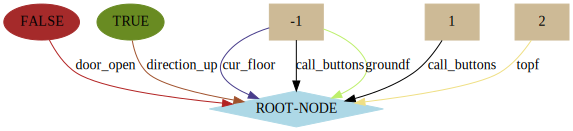

In [57]:
:dot state_as_graph

Another option is to use the `ANIMATION_FUNCTION` with the command `:show`. Note, however, that to use this you have to write an `ANIMATION_FUNCTION` for your B model.

The following B model contains such an `ANIMATION_FUNCTION` for the visualisation of Lift4. You can use what you have learned before to explore the visualisation.

In [58]:
::load
MODEL Lift0
DEFINITIONS SET_PREF_SHOW_EVENTB_ANY_VALUES==TRUE;
  ASSERT_LTL == "G( [push_call_button(groundf)] => F {cur_floor=groundf & door_open=TRUE})";
  Rconv == (topf-r+groundf);
  ANIMATION_FUNCTION == ( {r,c,i|r:groundf..topf & ((c=2 & i=0) or (c=1 & i=2))} <+ 
                            ({r,c,i|r:groundf..topf & Rconv:call_buttons & c=2 & i=1} \/
                             {r,c,i|r:groundf..topf & Rconv=cur_floor & c=1 &
                                    ((door_open=TRUE & i=3) or (door_open=FALSE & i=4))}
                              ) \/ {r,c,i| r=topf+1 & c=1 & 
                                       ((direction_up=TRUE & i=5) or (direction_up=FALSE & i=6)) } );
      ANIMATION_IMG0 == "images/CallButtonOff.gif";
      ANIMATION_IMG1 == "images/CallButtonOn.gif";
      ANIMATION_IMG2 == "images/LiftEmpty.gif";
      ANIMATION_IMG3 == "images/LiftOpen.gif";
      ANIMATION_IMG4 == "images/LiftClosed.gif";
      ANIMATION_IMG5 == "images/up_arrow.gif";
      ANIMATION_IMG6 == "images/down_arrow.gif";
      ANIMATION_RIGHT_CLICK(J,r) ==
               IF J=2 THEN
                push_call_button(topf-r+groundf)
               ELSIF J=1 THEN
                 CHOICE open_door OR close_door OR move_up OR move_down OR
                        reverse_lift_up OR reverse_lift_down
                 END
               END;
CONSTANTS groundf,topf
PROPERTIES
  topf : INTEGER & groundf : INTEGER & (groundf = -1) & (topf = 2) & (groundf < topf)
VARIABLES call_buttons,cur_floor,direction_up,door_open
INVARIANT
       cur_floor : (groundf .. topf) & 
       door_open : BOOL & 
       call_buttons : POW(groundf .. topf) &
       direction_up : BOOL &
       (door_open = TRUE => cur_floor : call_buttons)
INITIALISATION cur_floor := (groundf) || door_open := FALSE || call_buttons := ({}) || direction_up := TRUE
OPERATIONS
 move_up = SELECT door_open = FALSE & cur_floor < topf & direction_up = TRUE &
             # c.((c : INTEGER) & ((c : INTEGER) & (c > cur_floor) & (c : call_buttons))) &
            (cur_floor /: call_buttons) THEN
   cur_floor := ((cur_floor)+(1))
 END ;
 move_down = SELECT door_open = FALSE & cur_floor > groundf & (direction_up = FALSE) &
       # cu.((cu : INTEGER) & ((cu : INTEGER) & (cu < cur_floor) & (cu : call_buttons))) &
      (cur_floor /: call_buttons) THEN
   cur_floor := ((cur_floor)-(1))
 END ;
 reverse_lift_up = SELECT direction_up = FALSE & door_open = FALSE &
   # c.((c : INTEGER) & ((c : INTEGER) & (c > cur_floor) & (c : call_buttons))) & 
   ! l.((l : INTEGER) => (((l : INTEGER) & (l <= cur_floor) & (l >= groundf)) => (l /: call_buttons))) THEN
   direction_up := TRUE
 END ;
 reverse_lift_down = SELECT direction_up = TRUE & door_open = FALSE & 
  # cd.(cd : INTEGER & ((cd : INTEGER) & (cd < cur_floor) & (cd : call_buttons))) & 
  ! u.(u : INTEGER => (((u : INTEGER) & (u >= cur_floor) & (u <= topf)) => (u /: call_buttons))) THEN
  direction_up := FALSE
 END ;
 open_door = SELECT door_open = FALSE & (cur_floor : call_buttons) THEN
    door_open := TRUE
 END ;
 close_door = SELECT door_open = TRUE THEN
    door_open := FALSE || call_buttons := ((call_buttons)\({cur_floor}))
 END ;
 push_call_button(floor) = SELECT (floor : (groundf .. topf)) & (floor /: call_buttons) THEN 
     call_buttons := ((call_buttons)\/({floor}))
 END 
END

Loaded machine: Lift0

In [59]:
:help :show

```
:show
```

Show the machine's animation function visualisation for the current state.

The visualisation is static, any defined right-click options cannot be viewed or used.

In [60]:
:constants

Machine constants set up using operation 0: $setup_constants()

In [61]:
:init

Machine initialised using operation 1: $initialise_machine()

In [62]:
:show

<table style="font-family:monospace"><tbody>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="4" src="images/LiftClosed.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="5" src="images/up_arrow.gif"/></td>
<td style="padding:0px"></td>
</tr>
</tbody></table>

In [63]:
:browse

Machine: Lift0
Sets: (none)
Constants: groundf, topf
Variables: call_buttons, cur_floor, direction_up, door_open
Operations: 
push_call_button(-1)
push_call_button(0)
push_call_button(1)
push_call_button(2)

In [64]:
:exec push_call_button floor=-1

Executed operation: push_call_button(-1)

In [65]:
:show

<table style="font-family:monospace"><tbody>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="4" src="images/LiftClosed.gif"/></td>
<td style="padding:0px"><img alt="1" src="images/CallButtonOn.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="5" src="images/up_arrow.gif"/></td>
<td style="padding:0px"></td>
</tr>
</tbody></table>

In [66]:
:exec open_door

Executed operation: open_door()

In [67]:
:show

<table style="font-family:monospace"><tbody>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="3" src="images/LiftOpen.gif"/></td>
<td style="padding:0px"><img alt="1" src="images/CallButtonOn.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="5" src="images/up_arrow.gif"/></td>
<td style="padding:0px"></td>
</tr>
</tbody></table>

In [68]:
:exec close_door

Executed operation: close_door()

In [69]:
:show

<table style="font-family:monospace"><tbody>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="4" src="images/LiftClosed.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="5" src="images/up_arrow.gif"/></td>
<td style="padding:0px"></td>
</tr>
</tbody></table>

In [70]:
:browse

Machine: Lift0
Sets: (none)
Constants: groundf, topf
Variables: call_buttons, cur_floor, direction_up, door_open
Operations: 
push_call_button(-1)
push_call_button(0)
push_call_button(1)
push_call_button(2)

In [71]:
:exec push_call_button floor=1

Executed operation: push_call_button(1)

In [72]:
:show

<table style="font-family:monospace"><tbody>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="1" src="images/CallButtonOn.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="4" src="images/LiftClosed.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="5" src="images/up_arrow.gif"/></td>
<td style="padding:0px"></td>
</tr>
</tbody></table>

In [73]:
:exec move_up

Executed operation: move_up()

In [74]:
:show

<table style="font-family:monospace"><tbody>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="1" src="images/CallButtonOn.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="4" src="images/LiftClosed.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="2" src="images/LiftEmpty.gif"/></td>
<td style="padding:0px"><img alt="0" src="images/CallButtonOff.gif"/></td>
</tr>
<tr>
<td style="padding:0px"><img alt="5" src="images/up_arrow.gif"/></td>
<td style="padding:0px"></td>
</tr>
</tbody></table>

This concludes the overview over the ProB jupyter notebook kernel.